In [3]:
import pandas as pd

dir = '/Users/qasem/PycharmProjects/large-manifold-nbs/data/'

def cmat_cnt(subject, epoch):
    """ load centered connectivity matrix to a numpy array. epoch in baseline, early, late"""
    return pd.read_csv(dir+'cmat/cnt/cnt_'+str(subject)+'_'+epoch+'.csv').to_numpy()

In [4]:
from brainspace.gradient.utils import dominant_set

In [5]:
cmat = cmat_cnt(1, 'baseline')

In [6]:
thresh = .9

In [7]:
# !pip install bctpy==0.5.2 --quiet

In [8]:
import bct

In [9]:
ts = pd.read_csv(dir+'ts/ts_1_baseline.csv')
ts.head()

,7Networks_LH_Vis_1,7Networks_LH_Vis_2,7Networks_LH_Vis_3,7Networks_LH_Vis_4,7Networks_LH_Vis_5,7Networks_LH_Vis_6,7Networks_LH_Vis_7,7Networks_LH_Vis_8,7Networks_LH_Vis_9,7Networks_LH_Vis_10,...,Left Hippocampus,Left Amygdala,Left Accumbens,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens
0,-0.707022,-0.763647,0.091984,-0.364270,-0.671012,0.649847,-0.246103,0.754983,0.631594,0.808759,...,-0.039909,-0.296537,0.289511,-0.253907,-0.810298,-2.000160,-0.479996,-0.109435,-0.101183,-0.529745
1,-1.313980,-1.436940,-1.149532,-0.640217,-0.504047,-0.101759,-1.111763,1.337396,-0.583194,0.339601,...,-2.327223,-1.698804,0.560162,-0.652799,-0.885699,-1.546196,-1.642955,-1.903944,-1.821804,-1.266036
2,-1.175622,-1.051546,-1.235031,-0.431280,0.932604,-0.134707,-1.171876,1.790176,-1.433821,0.045582,...,1.131981,0.295590,0.074461,1.340012,0.860470,-0.500277,1.571292,0.372534,-0.311690,1.368992
3,-0.353504,-0.274848,-0.234933,-0.489042,2.243884,0.170842,-0.643113,1.357257,-1.249307,-0.108199,...,1.107219,0.715183,0.545290,0.286716,1.322081,0.247186,-0.475064,1.685276,0.336718,0.141097
4,0.700392,-0.007258,0.933005,-0.998473,1.932399,0.061735,-0.015147,-0.129264,-0.079308,-0.225130,...,-0.512820,0.872590,-0.337517,0.173958,-0.530911,-1.526489,-0.450150,0.004471,0.469072,-1.424279


In [10]:
r = pd.read_csv(dir+'regions_sorted.csv').loc[:, ['region', '7net', '17net']]
r.head()

,region,7net,17net
0,7Networks_LH_Vis_1,Vis,DorsAttnA
1,7Networks_LH_Vis_2,Vis,VisCent
2,7Networks_LH_Vis_3,Vis,DorsAttnA
3,7Networks_LH_Vis_4,Vis,VisCent
4,7Networks_LH_Vis_5,Vis,DefaultC


In [11]:
import matplotlib.pyplot as plt

range of participation coefficient:  -1464.3569161435103 0.9295009167953706


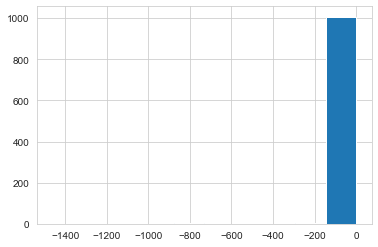

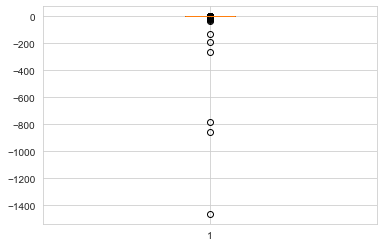

In [12]:
# compute participation coefficient
coefs = bct.participation_coef(cmat, r['17net'].to_numpy())

print('range of participation coefficient: ', min(coefs), max(coefs))

plt.hist(coefs)
plt.show()

plt.boxplot(coefs)
plt.show()

range of participation coefficient:  -1608.2997661150002 0.8515691896865893


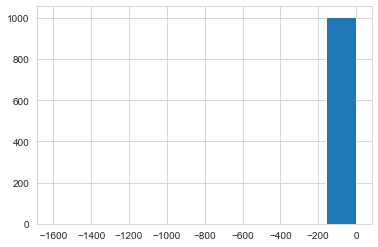

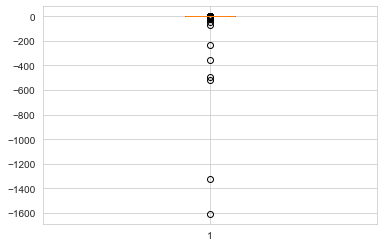

In [13]:
# compute participation coefficient
coefs = bct.participation_coef(cmat, r['7net'].to_numpy())

print('range of participation coefficient: ', min(coefs), max(coefs))

plt.hist(coefs)
plt.show()

plt.boxplot(coefs)
plt.show()

In [14]:
regions = pd.read_csv(dir+'regions_sorted.csv').loc[:, ['region', '7net', '17net']]
regions['hemi'] = regions['region'].apply(lambda rname:
                                          rname[10] if rname[0]=='7'    # for cortext
                                          else rname[0])                # for subcortex

In [15]:
import numpy as np

In [16]:
def compute_measures(cmat, thresh=.9, net='7net'):
    """
    from https://github.com/danjgale/adaptation-manifolds
    Calculate region-level connectivity properties pertaining to integration
    and segregation

    Parameters
    ----------
    cmat : np.ndarray
        Dense connectivity matrix
    thresh : float, optional
        Row-wise threshold. By default .9, which is identical to the threshold
        in cograd.gradients

    Returns
    -------
    pd.DataFrame
        Functional connectivity measures for each region
    """
    assert net in ('7net', '17net')

    # affilitation vectors
    network_aff = regions[net].to_numpy()
    network_hemi_aff = (regions['hemi']+regions[net].astype(str)).to_numpy()

    # threshold and binarize
    x = dominant_set(cmat, k=1-thresh,
                     is_thresh=False, as_sparse=False)
    x_bin = (x != 0).astype(float)

    measures = pd.DataFrame({
        'region': regions['region'],
        'hemi': regions['hemi'],
        'network_aff': network_aff,
        '7net': regions['7net'],
        '17net': regions['17net'],
        'participation': bct.participation_coef(x, network_aff, 'out'),
        'participation_h': bct.participation_coef(x, network_hemi_aff, 'out'),
        'module_degree': bct.module_degree_zscore(x_bin, network_aff, 2),
        'module_degree_h': bct.module_degree_zscore(x_bin, network_hemi_aff, 2),
        'strength': np.sum(x, axis=1)
    })
    return measures

In [17]:
compute_measures(cmat, thresh=.9, net='7net')

/Users/qasem/opt/anaconda3/envs/brainv/lib/python3.9/site-packages/bct/algorithms/centrality.py:661: RuntimeWarning: invalid value encountered in divide
  Z[np.where(ci == i)] = (Koi - np.mean(Koi)) / np.std(Koi)


,region,hemi,network_aff,7net,17net,participation,participation_h,module_degree,module_degree_h,strength
0,7Networks_LH_Vis_1,L,Vis,Vis,DorsAttnA,0.830406,0.901215,-1.704818,-1.769278,5.479805
1,7Networks_LH_Vis_2,L,Vis,Vis,VisCent,0.783049,0.885489,-0.948687,-0.952688,7.182921
2,7Networks_LH_Vis_3,L,Vis,Vis,DorsAttnA,0.791596,0.885872,-1.251139,-1.224885,6.467952
3,7Networks_LH_Vis_4,L,Vis,Vis,VisCent,0.552824,0.771538,0.563576,0.476344,8.396174
4,7Networks_LH_Vis_5,L,Vis,Vis,DefaultC,0.790643,0.877888,-1.553592,-1.429032,6.298151
...,...,...,...,...,...,...,...,...,...,...
1007,Right Putamen,R,Striatum,Striatum,StriatumRight,0.774661,0.878772,0.615457,0.000000,7.329652
1008,Right Pallidum,R,Striatum,Striatum,StriatumRight,0.782721,0.866481,-1.107823,0.000000,5.014076
1009,Right Hippocampus,R,Striatum,Striatum,StriatumRight,0.710900,0.851409,0.615457,0.000000,7.682310
1010,Right Amygdala,R,Striatum,Striatum,StriatumRight,0.701107,0.841241,0.615457,0.000000,6.270892


apply it to reference mean connectivity matrix

In [18]:
ref_cmat = pd.read_csv('data/cmat/ref_mean.csv').to_numpy()
# conn mat for baseline riemannian mean of all subjects

In [19]:
ref_measures = compute_measures(ref_cmat, thresh=.9, net='7net')

/Users/qasem/opt/anaconda3/envs/brainv/lib/python3.9/site-packages/bct/algorithms/centrality.py:661: RuntimeWarning: invalid value encountered in divide
  Z[np.where(ci == i)] = (Koi - np.mean(Koi)) / np.std(Koi)


In [20]:
ref_measures.to_csv('data/cmat/ref_measures.csv', index=False)

In [21]:
ref_measures

,region,hemi,network_aff,7net,17net,participation,participation_h,module_degree,module_degree_h,strength
0,7Networks_LH_Vis_1,L,Vis,Vis,DorsAttnA,0.685685,0.789521,-2.386353,-2.376239,0.684628
1,7Networks_LH_Vis_2,L,Vis,Vis,VisCent,0.480485,0.691321,-1.247108,-0.946081,0.864430
2,7Networks_LH_Vis_3,L,Vis,Vis,DorsAttnA,0.439140,0.699347,-1.308689,-1.303621,0.898468
3,7Networks_LH_Vis_4,L,Vis,Vis,VisCent,0.125002,0.543175,2.078258,1.854643,1.207425
4,7Networks_LH_Vis_5,L,Vis,Vis,DefaultC,0.530043,0.729754,-2.078449,-2.018699,0.767989
...,...,...,...,...,...,...,...,...,...,...
1007,Right Putamen,R,Striatum,Striatum,StriatumRight,0.255933,0.621671,0.000000,0.000000,3.171855
1008,Right Pallidum,R,Striatum,Striatum,StriatumRight,0.233334,0.563090,0.000000,0.000000,1.890005
1009,Right Hippocampus,R,Striatum,Striatum,StriatumRight,0.293347,0.636235,0.000000,0.000000,2.998724
1010,Right Amygdala,R,Striatum,Striatum,StriatumRight,0.273513,0.626733,0.000000,0.000000,2.962123


correlation with eccentricity in baseline averaged over all subjects

In [22]:
dfg = pd.read_csv('data/gradient_10.csv',
                  usecols=['epoch', 'subject', 'region', '7net', '17net', 'g1', 'g2', 'g3'])
dfg = dfg.set_index(['epoch', 'subject', 'region', '7net', '17net']).loc['baseline']
dfg.columns.name = 'g'
dfg['ecc'] = (dfg['g1']**2 + dfg['g2']**2 + dfg['g3']**2).apply(np.sqrt)
dfg = dfg.groupby(level=['region', '7net', '17net'])['ecc'].mean()
dfg

region                    7net      17net        
7Networks_LH_Cont_Cing_1  Cont      SalVentAttnB     2.021287
7Networks_LH_Cont_Cing_2  Cont      ContC            2.474936
7Networks_LH_Cont_Cing_3  Cont      ContC            2.377306
7Networks_LH_Cont_Cing_4  Cont      ContA            1.886938
7Networks_LH_Cont_Cing_5  Cont      ContC            2.276133
                                                       ...   
Right Caudate             Striatum  StriatumRight    1.354085
Right Hippocampus         Striatum  StriatumRight    1.314940
Right Pallidum            Striatum  StriatumRight    1.151054
Right Putamen             Striatum  StriatumRight    1.301208
Right Thalamus            Striatum  StriatumRight    1.117757
Name: ecc, Length: 1012, dtype: float64

In [23]:
ref_measures = ref_measures.set_index(['region', '7net', '17net']).join(dfg)

In [24]:
import seaborn

In [25]:
from scipy.stats import pearsonr

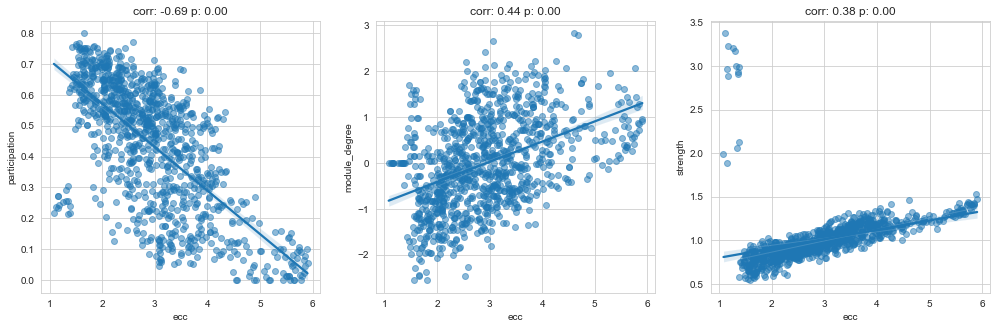

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, col in enumerate(['participation', 'module_degree', 'strength']):
    seaborn.regplot(x='ecc', y=col, data=ref_measures, ax=axes[i], scatter_kws={'alpha':.5})
    corr, p = pearsonr(ref_measures['ecc'], ref_measures[col])
    axes[i].set_title(f'corr: {corr:.2f} p: {p:.2f}')

# plt.savefig('graph-measures-corr.svg', format='svg')
plt.show()

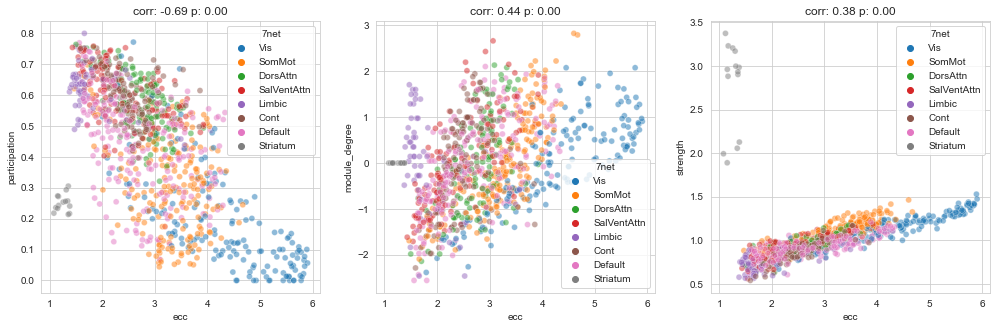

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, col in enumerate(['participation', 'module_degree', 'strength']):
    seaborn.scatterplot(x='ecc', y=col, data=ref_measures, ax=axes[i], hue='7net', alpha=.5)
    corr, p = pearsonr(ref_measures['ecc'], ref_measures[col])
    axes[i].set_title(f'corr: {corr:.2f} p: {p:.2f}')

plt.show()

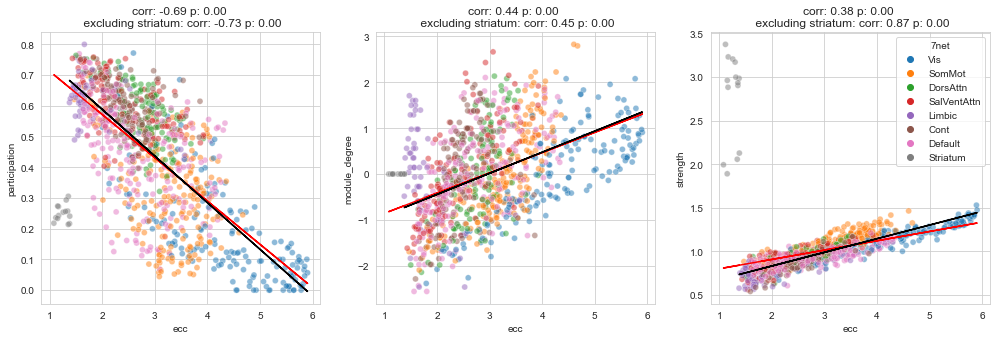

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, col in enumerate(['participation', 'module_degree', 'strength']):
    seaborn.scatterplot(x='ecc', y=col, data=ref_measures, ax=axes[i], hue='7net', alpha=.5)
    corr, p = pearsonr(ref_measures['ecc'], ref_measures[col])

    x, y = ref_measures['ecc'], ref_measures[col]
    m, b = np.polyfit(x, y, 1)
    axes[i].plot(x, m*x + b, color='red')

    # exclude subcortex
    measures_exc_str = ref_measures[ref_measures.index.get_level_values(level='7net') != 'Striatum']
    x, y = measures_exc_str['ecc'], measures_exc_str[col]
    m, b = np.polyfit(x, y, 1)
    axes[i].plot(x, m*x + b, color='black')
    corr_no_str, p_no_str = pearsonr(measures_exc_str['ecc'], measures_exc_str[col])

    axes[i].set_title(f'corr: {corr:.2f} p: {p:.2f} \n excluding striatum: corr: {corr_no_str:.2f} p: {p_no_str:.2f}')

axes[0].get_legend().remove()
axes[1].get_legend().remove()
plt.savefig('graph-measures-corr-excluding-striatum.svg', format='svg')
plt.show()

In [29]:
# pallette for 7 networks #

# load cmap17 values from txt file
dir_cmap = '/Users/qasem/PycharmProjects/cortical-400-subcortical-RL-task-rest/'

def yeo_cmap(as_palette=False, networks=7):
    """load cmap7 or cmap17 from txt file in directory"""
    assert networks in (7, 17)
    cmap = {}
    with open(dir_cmap + f'_cmap{networks}.txt', 'r') as f:
        for line in f.readlines():
            k, r, g, b = line.split()
            cmap[k] = (int(r), int(g), int(b))
    cmap = {k: np.array(v) / 255 for k, v in cmap.items()}

    if as_palette:
        return seaborn.color_palette(cmap.values())
    else:
        return cmap


seaborn.set(style='white', context='notebook', rc={'figure.figsize': (7, 5)})
cmap8 = yeo_cmap(as_palette=False, networks=7)
# remove keys 'Cerebellum' and 'Subcortex'
cmap8.pop('Cerebellum')
cmap8.pop('Subcortex')
cmap8

{'Vis': array([0.46666667, 0.07843137, 0.54901961]),
 'SomMot': array([0.2745098 , 0.49411765, 0.68627451]),
 'DorsAttn': array([0.        , 0.45882353, 0.02745098]),
 'SalVentAttn': array([0.76470588, 0.23137255, 1.        ]),
 'Limbic': array([0.85882353, 0.97647059, 0.64705882]),
 'Cont': array([0.90196078, 0.58431373, 0.12941176]),
 'Default': array([0.80392157, 0.25490196, 0.31372549]),
 'Striatum': array([0., 0., 0.])}

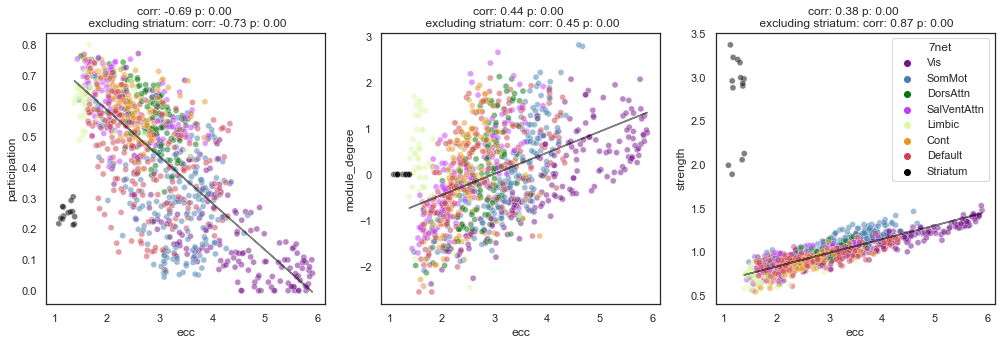

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, col in enumerate(['participation', 'module_degree', 'strength']):
    seaborn.scatterplot(x='ecc', y=col, data=ref_measures, ax=axes[i], hue='7net', alpha=.5,
                        hue_order=cmap8.keys(), palette=seaborn.color_palette(cmap8.values()))
    corr, p = pearsonr(ref_measures['ecc'], ref_measures[col])

    # x, y = ref_measures['ecc'], ref_measures[col]
    # m, b = np.polyfit(x, y, 1)
    # axes[i].plot(x, m*x + b, color='red')

    # exclude subcortex
    measures_exc_str = ref_measures[ref_measures.index.get_level_values(level='7net') != 'Striatum']
    x, y = measures_exc_str['ecc'], measures_exc_str[col]
    m, b = np.polyfit(x, y, 1)
    axes[i].plot(x, m*x + b, alpha=.5, color='black')
    corr_no_str, p_no_str = pearsonr(measures_exc_str['ecc'], measures_exc_str[col])

    axes[i].set_title(f'corr: {corr:.2f} p: {p:.2f} \n excluding striatum: corr: {corr_no_str:.2f} p: {p_no_str:.2f}')

axes[0].get_legend().remove()
axes[1].get_legend().remove()
plt.savefig('graph-measures-corr-excluding-striatum-colored.png', dpi=300)
plt.show()

plot on brain

on cortex

In [31]:
regions_ordered = pd.read_csv('data/regions_sorted.csv')['region']

In [32]:
import nibabel
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
from surfplot import Plot

fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


on subcortex

In [33]:
from enigmatoolbox.plotting import plot_subcortical

In [34]:
subcortex_order = ['Left Accumbens',
                   'Left Amygdala',
                   'Left Caudate',
                   'Left Hippocampus',
                   'Left Pallidum',
                   'Left Putamen',
                   'Left Thalamus',
                   # 'Left Ventricles',
                   'Right Accumbens',
                   'Right Amygdala',
                   'Right Caudate',
                   'Right Hippocampus',
                   'Right Pallidum',
                   'Right Putamen',
                   'Right Thalamus',
                   # 'Right Ventricles',
                   ]

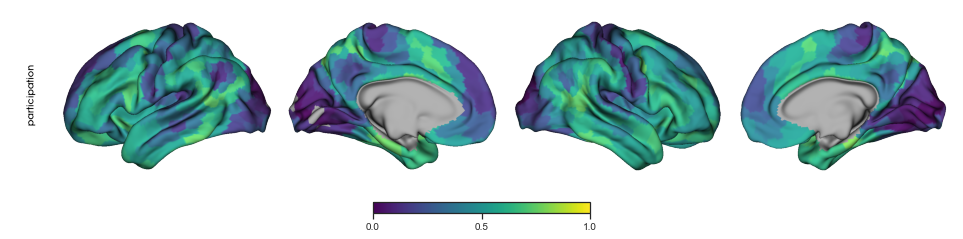

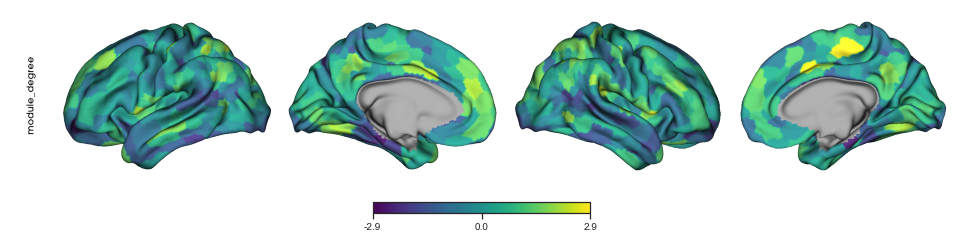

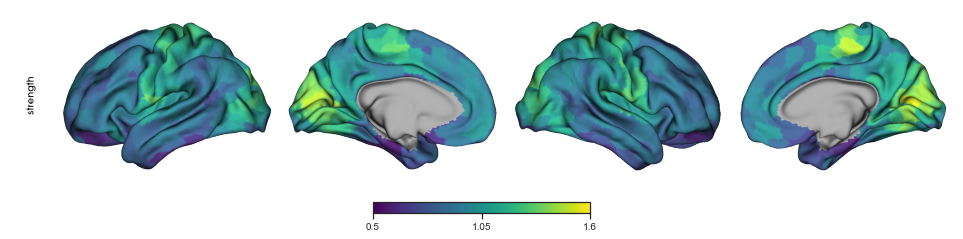

In [35]:
for measure, col_range in zip(['participation', 'module_degree', 'strength'],
                              [(0, 1), (-2.9, 2.9), (.5, 1.6)]):

    data = ref_measures[measure]

    # on cortex
    data_cortex = map_to_labels(data.loc[regions_ordered],
                         vertices, mask=(vertices != 0))
    p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300), label_text=[measure])
    p.add_layer(data_cortex, cbar=True, color_range=col_range)
    figure = p.build()
    figure.savefig(f'{measure}_cortex.svg', dpi=300, format='svg')

    # on subcortex
    plot_subcortical(data.loc[subcortex_order],
                        size=(800, 400), cmap='viridis',
                        color_bar=True, color_range=col_range, ventricles=False,
                        screenshot=True, filename=f'{measure}_subcortex.png')